# LSTM for new type of datasets

In [40]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

import pandas as pd
import numpy as np

import plotly.express as px
from torch.optim import Adam

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

## Classes

In [41]:
class SequentDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
        self.n_dot_parameters = n_dot_parameters
        self.n_dots = n_dots
        self.X_, self.y_ = self.__make_stack(dataframe)
        # print(self.X_.shape)
        # print(self.y_.shape)

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

    def __make_stack(self, df: pd.DataFrame):
        seq_amount = df.shape[0] - 2 * self.n_dots - 1
        X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        for i in range(seq_amount):
            X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            y[i, :, :] = torch.reshape(torch.tensor(df.values[i+1:i+1+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))

        # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
        return (X, y)

In [42]:
class DatasetForTrain(Dataset):
    def __init__(self, x, y):
        self.X_ = x
        self.y_ = y

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

In [43]:
class Subset(Dataset):
    """
    Subset of a dataset at specified indices.
    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        if self.indices.shape == ():
            print('this happens: Subset')
            return 1
        else:
            return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

In [44]:
# class CrossValidationTrainSubset(Dataset):
#     def __init__(self, dataset, n_parts=5):
#         self.dataset_ = dataset
#         self.n_parts_ = n_parts
#         self.n_val_samples_ = len(dataset) // (n_train_parts + n_val_parts)
        
#     def __len__(self):
#         return len(self.dataset_) * (self.n_parts_ - 1) / (self.n_train_parts_ + self.n_val_parts_)
        
#     def __getitem__(self, idx):
#         train_indexes = np.concatenate([np.arange(len(dataset))[:idx * num_val_samples], np.arange(len(dataset))[(idx + 1) * num_val_samples:]])
#         return self.dataset[train_indexes]
    
    
# class CrossValidationValidationSubset(Dataset):
#     def __init__(self, dataset, n_parts=5):
#         self.dataset_ = dataset
#         self.n_parts_ = n_parts
#         self.n_val_samples_ = len(dataset) // (n_train_parts + n_val_parts)
        
#     def __len__(self):
#         return len(self.dataset_) / (self.n_train_parts_ + self.n_val_parts_)       
     
#     def __getitem__(self, idx):
#         val_indexes = np.arange(len(dataset))[i * num_val_samples:(i + 1) * num_val_samples]
#         return self.dataset[val_indexes]

# def make_cross_validation(dataset, n_parts=5):
#     train = CrossValidationTrainSubset(dataset, n_train_parts, n_val_parts)
#     train_cross_loader = DataLoader(train, batch_size=1, shuffle=True)
#     validation = CrossValidationValidationSubset(dataset, n_train_parts, n_val_parts)
#     validation_cross_loader = DataLoader(validation, batch_size=1, shuffle=False)
#     return train_cross_loader, validation_cross_loader

In [45]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=4, num_layers=10):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # x = x.to(device)
        batch_size = x.size(0)
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        # self.h = self.h.to(device)
        self.c = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        # self.c = self.c.to(device)
        out, _ = self.lstm(x, (self.h, self.c))

        # print(out.size())

        # Pass through fully connected layer
        out = self.linear(out)  # We want the output corresponding to the last time step
        return out

In [46]:
N_DOTS = 100
BATCH_SIZE = 8
N_DOT_PARAMETERS = 4
N_LSTM_LAYERS = 1

In [47]:
trajectory_train = pd.read_csv("../../sets_for_article/dash_slope_train.csv")
trajectory_test = pd.read_csv("../../sets_for_article/dash_slope_test.csv")

trajectory_train['t'] = 1
trajectory_test['t'] = 1

In [48]:
fig = px.line_3d(trajectory_train, x="X", y="Y", z="Z", color='I')
fig.show()

In [49]:
num_train = trajectory_train['I'].max()
dashes_train = []
# num_train=0
for i in range(num_train+1):
    temp = trajectory_train[trajectory_train['I'] == i]
    temp_dataset = SequentDataset(temp[['t','X','Y','Z']], N_DOTS, N_DOT_PARAMETERS)
    dashes_train.append(temp_dataset)


num_test = trajectory_test['I'].max()
dashes_test = []
# num_test=0
for i in range(num_test+1):
    temp = trajectory_test[trajectory_test['I'] == i]
    temp_dataset = SequentDataset(temp[['t','X','Y','Z']], N_DOTS, N_DOT_PARAMETERS)
    dashes_test.append(temp_dataset)

In [50]:
len(dashes_test[0])

799

In [51]:
for_train_x = torch.zeros(1,dashes_train[0][0][0].size()[0],N_DOT_PARAMETERS)
for_train_y = torch.zeros(1,dashes_train[0][0][1].size()[0],N_DOT_PARAMETERS)
for dash in dashes_train:
    temp_x, temp_y = dash[:]
    # print(temp_x)
    # break
    for_train_x = torch.cat([for_train_x,temp_x],dim=0)
    for_train_y = torch.cat([for_train_y,temp_y],dim=0)

# Указание индекса строки, которую нужно удалить
row_index_to_delete = 0

# Генерация индексов строк, которые нужно сохранить
indices_to_keep = torch.tensor([i for i in range(for_train_x.size(0)) if i != row_index_to_delete])

for_train_x = torch.index_select(for_train_x, dim=0, index=indices_to_keep)
for_train_y = torch.index_select(for_train_y, dim=0, index=indices_to_keep)

train = DatasetForTrain(for_train_x, for_train_y)

In [52]:
model = LSTMModel(input_size=N_DOT_PARAMETERS, num_layers=N_LSTM_LAYERS)
# loss_model = nn.L1Loss()
loss_model = nn.HuberLoss()
# loss_model = nn.MSELoss()
# opt = Adam(model.parameters(), lr=0.005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

In [53]:
opt = Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

In [54]:
# model.load_state_dict(torch.load("lstm_dach_28_10.pt"))

In [55]:
def train_step():
    model.train()
    train_loss = []

    for X, y in train_loader:
        pred = model(X)
        loss = loss_model(pred, y)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()

        opt.step()
    mean_train_loss = sum(train_loss)/len(train_loss)
    return mean_train_loss

In [56]:
def validation_step():
    model.eval()
    with torch.no_grad():
        val_loss = []
        for X, y in val_loader:
            pred = model(X)
            loss = loss_model(pred, y)
            val_loss.append(loss.item())

        mean_val_loss = sum(val_loss)/len(val_loss)
        
        return mean_val_loss

In [ ]:
EPOCH = 30
N_DASH = len(dashes_train)
train_losses = []
val_losses = []

kf = KFold(n_splits=5, shuffle = True)

for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):

    print('Fold : {}'.format(fold))

    dataset_train = Subset(train, train_idx)
    dataset_valid = Subset(train, valid_idx)
    
    train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)
    
    for epoch in range(EPOCH):
        # Обучение
        mean_train_loss = train_step()
        train_losses.append(mean_train_loss)

    # Валидация
        mean_val_loss = validation_step()
        val_losses.append(mean_val_loss)

        print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.4f}, val_loss = {mean_val_loss:.4f}")

        lr_scheduler.step()
        lr = lr_scheduler.get_last_lr()

Fold : 0
Epoch [1/30], train_loss = 8.0559, val_loss = 6.8328
Epoch [2/30], train_loss = 6.0157, val_loss = 5.0768
Epoch [3/30], train_loss = 4.4982, val_loss = 3.7495
Epoch [4/30], train_loss = 3.3533, val_loss = 2.8402
Epoch [5/30], train_loss = 2.5469, val_loss = 2.1123
Epoch [6/30], train_loss = 2.0171, val_loss = 1.7507
Epoch [7/30], train_loss = 1.6613, val_loss = 1.4615
Epoch [8/30], train_loss = 1.4144, val_loss = 1.2615
Epoch [9/30], train_loss = 1.2078, val_loss = 1.0773


In [55]:
# torch.save(model.state_dict(),"lstm_dach_28_10.pt")

<function matplotlib.pyplot.show(close=None, block=None)>

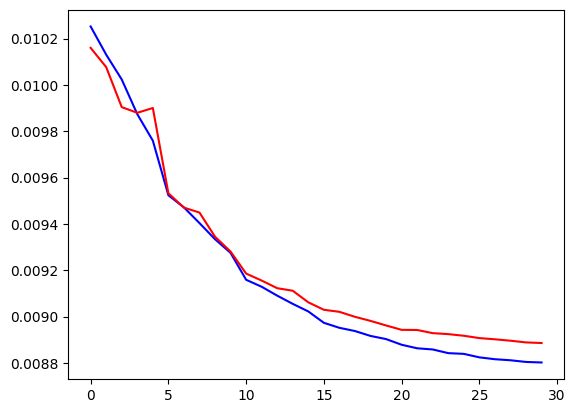

In [51]:
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.show

In [52]:
all_predictions = []
model.eval()
with torch.no_grad():
    for dash in dashes_train:
        sequence, _ = dash[0]
        predictions = []
        test_loader = DataLoader(dash, batch_size=8, shuffle=False)
        for X,y in test_loader:
            for i in range(N_DOTS, len(dash)):
                y_pred = model(X)
                predictions.append(y_pred[0, -1, :])
                X[0, :-1, :] = X.clone()[0, 1:, :]
                X[0, -1, :] = y_pred[0, -1, :]
            all_predictions.append(predictions)
            break

In [53]:
pred_data = pd.DataFrame([[0,0,0,0,0]], columns=["Time", "X", "Y", "Z", "I"])

for i in range(len(all_predictions)):
    p_x = pd.DataFrame(np.vstack(list(map(lambda x: x.detach().numpy(), all_predictions[i]))), columns=["Time", "X", "Y", "Z"])
    p_x['I'] = "Predict_" + str(i)
    _, y  = dashes_train[i][:]
    p_y = pd.DataFrame(y.detach().numpy()[:, 0, :], columns=["Time", "X", "Y", "Z"])
    p_y['I'] = "True_" + str(i)
    pred_data = pd.concat([pred_data,p_x,p_y],axis=0)

aaaab = pred_data.drop(pred_data.index[0], inplace=False)


In [54]:
fig = px.line_3d(aaaab, x="X", y="Y", z="Z", color='I')
fig.show()